###过拟合和欠拟合

学习如何应对过度拟合很重要。尽管通常可以在训练集上达到高精度，但我们真正想要的是开发能够很好地推广到测试集（或之前未见的数据）的模型。

过度拟合的反面是欠拟合。当测试数据仍有改进空间时，就会发生欠拟合。发生这种情况的原因有很多：如果模型不够强大，模型过于规范化，或者仅仅是没有经过足够长时间的训练。这意味着网络尚未学习训练数据中的相关模式。

但是，如果训练时间过长，则模型将开始过拟合并从训练数据中学习无法推广到测试数据的模式。我们需要保持平衡。如下所述，了解如何训练适当的时期是一项有用的技能。

为了防止过度拟合，最好的解决方案是使用更完整的训练数据。数据集应涵盖模型应处理的所有输入范围。仅当涉及新的有趣案例时，其他数据才有用。

经过更完整数据训练的模型自然会更好地推广。当这不再可能时，下一个最佳解决方案是使用正则化之类的技术。这些因素限制了模型可以存储的信息的数量和类型。如果一个网络只能存储少量模式，那么优化过程将迫使它专注于最突出的模式，这些模式有更好的概括机会。

在本笔记本中，我们将探索几种常见的正则化技术，并使用它们对分类模型进行改进。

###设定
在开始之前，请导入必要的软件包：

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [0]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pathlib
import shutil
import tempfile


In [0]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

###希格斯数据集
本教程的目的不是做粒子物理学，所以不要关注数据集的细节。它包含11000000个示例，每个示例具有28个功能以及一个二进制类标签。

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 175s 0us/step


In [0]:
FEATURES = 28

的tf.data.experimental.CsvDataset类可以被用来直接从没有中间减压工序的gzip文件读CSV记录。

In [0]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES + 1),compression_type="GZIP")

该csv阅读器类返回每个记录的标量列表。以下函数将该标量列表重新打包为（feature_vector，label）对。

In [0]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

当处理大量数据时，TensorFlow效率最高。

因此，与其单独重新包装每一行，不如创建一个新的版本Dataset，该批次需要10000个示例，将pack_row函数应用于每个批次，然后将批次拆分回各个记录：

In [0]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

看一下这个新书的一些记录packed_ds。

这些功能尚未完全标准化，但这足以满足本教程的要求。

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


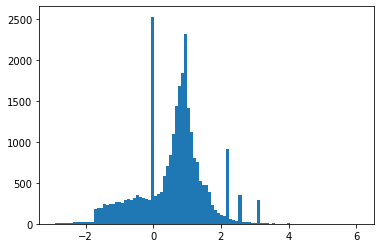

In [10]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(),bins=101)

为了使本教程相对简短，仅使用前1000个样本进行验证，然后使用10000个样本进行培训：

In [0]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE =  int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

该Dataset.skip和Dataset.take方法使这个容易。

同时，使用该Dataset.cache方法来确保加载器不需要在每个时期重新读取文件中的数据：

In [0]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

这些数据集返回单个示例。使用该.batch方法可以创建适当大小的批次进行训练。批处理之前，还记得要.shuffle和.repeat训练集。

In [0]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

###证明过度拟合
防止过度拟合的最简单方法是从一个小的模型开始：一个具有少量可学习参数（由层数和每层单位数确定）的模型。在深度学习中，模型中可学习参数的数量通常称为模型的“容量”。

直观地讲，具有更多参数的模型将具有更多的“记忆能力”，因此将能够轻松学习训练样本与其目标之间的理想的字典式映射，这种映射没有任何泛化能力，但是在进行预测时这将是无用的根据以前看不见的数据。

始终牢记这一点：深度学习模型往往擅长拟合训练数据，但真正的挑战是泛化而不是拟合。

另一方面，如果网络的存储资源有限，则将无法轻松地学习映射。为了最大程度地减少损失，它必须学习具有更强预测能力的压缩表示形式。同时，如果您使模型过小，将难以拟合训练数据。“容量过多”和“容量不足”之间存在平衡。

不幸的是，没有神奇的公式来确定模型的正确大小或体系结构（根据层数或每层的正确大小）。您将不得不尝试使用一系列不同的体系结构。

为了找到合适的模型大小，最好从相对较少的图层和参数开始，然后开始增加图层的大小或添加新图层，直到看到验证损失的收益递减为止。

从仅用layers.Dense作基线的简单模型开始，然后创建较大的版本并进行比较。

###训练程序
如果在训练过程中逐渐降低学习速度，许多模型的训练效果会更好。用于optimizers.schedules随着时间的推移降低学习率：

In [0]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

上面的代码将a设置为schedules.InverseTimeDecay在1000个历元时将学习率夸大地降低为基本率的1/2，在2000个历时时为1/3，依此类推。

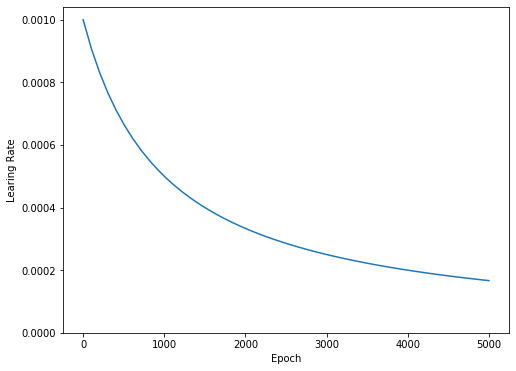

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH,lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learing Rate')

本教程中的每个模型都将使用相同的训练配置。因此，从回调列表开始，以可重用的方式设置它们。

本教程的培训持续了很短的时间。为了减少日志记录噪声tfdocs.EpochDots，请.在每个时期简单地使用，每100个时期使用完整的指标。

接下来包括callbacks.EarlyStopping避免冗长和不必要的培训时间。请注意，此回调设置为监视val_binary_crossentropy，而不是val_loss。这种差异稍后将变得很重要。

使用callbacks.TensorBoard生成的培训TensorBoard日志。

In [0]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy',patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

同样每个模型都将使用相同Model.compile和Model.fit设置：

In [0]:
def compile_and_fit(model,name,optimizer=None,max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy','binary_crossentropy'])
  model.summary()

  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=validate_ds,
      callbacks=get_callbacks(name),
      verbose=0
  )
  return history

###小模型
首先训练线性模型：

In [0]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(1,activation='sigmoid')
])

In [0]:
size_histories = {}

In [21]:
size_histories['Tiny'] = compile_and_fit(tiny_model,'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4782,  binary_crossentropy:0.8141,  loss:0.8141,  val_accuracy:0.5150,  val_binary_crossentropy:0.7346,  val_loss:0.7346,  
....................................................................................................
Epoch: 100, accuracy:0.6480,  binary_crossentropy:0.6275,  loss:0.6275,  val_accuracy:0.6400,  val_binary_crossentropy:0.6267,  val_loss:0.6267,  
....................................................................................................
Epoch: 200, accuracy:0.66

现在检查模型如何：

(0.5, 0.7)

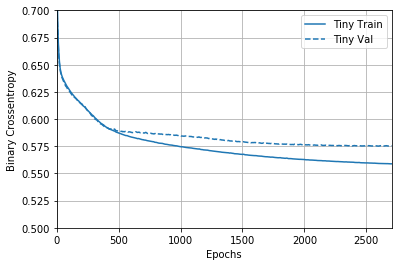

In [22]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy',smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

###小模型
若要查看是否可以击败小型模型的性能，请逐步训练一些大型模型。

尝试两个每个都有16个单位的隐藏层：

In [0]:
small_model = tf.keras.Sequential([
  layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
  layers.Dense(16,activation='elu'),
  layers.Dense(1,activation='sigmoid')
])

In [24]:
size_histories['Small'] = compile_and_fit(small_model,'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4892,  binary_crossentropy:0.8339,  loss:0.8339,  val_accuracy:0.5390,  val_binary_crossentropy:0.7273,  val_loss:0.7273,  
....................................................................................................
Epoch: 100, accuracy:0.6563,  binary_crossentropy:0.6179,  loss:0.6179,  val_accuracy:0.6380,  val_binary_crossentropy:0.6274,  val_loss:0.

###中型
现在尝试3个隐藏层，每个隐藏层64个单位：

In [0]:
medium_model = tf.keras.Sequential([
  layers.Dense(64,activation='elu',input_shape=(FEATURES,)),
  layers.Dense(64,activation='elu'),
  layers.Dense(64,activation='elu'),
  layers.Dense(1,activation='sigmoid')
])

并使用相同的数据训练模型：

In [26]:
size_histories['Medium'] = compile_and_fit(medium_model,'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5360,  binary_crossentropy:0.6954,  loss:0.6954,  val_accuracy:0.6080,  val_binary_crossentropy:0.6679,  val_loss:0.6679,  
....................................................................................................
E

###大型模型
作为练习，您可以创建一个更大的模型，并查看它开始过拟合的速度。接下来，让我们将具有更大容量的网络添加到此基准中，远远超出问题所能保证的范围：

In [0]:
large_model = tf.keras.Sequential([
  layers.Dense(512,activation='elu',input_shape=(FEATURES,)),
  layers.Dense(512,activation='elu'),
  layers.Dense(512,activation='elu'),
  layers.Dense(512,activation='elu'),
  layers.Dense(1,activation='sigmoid')
])

再次，使用相同的数据训练模型：

In [28]:
size_histories['large'] = compile_and_fit(large_model,'sizes/large')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5094,  binary_crossentropy:0.8321,  loss:0.8321,  val_accuracy:0.5530,  val_binary_crossentr

###绘制训练和验证损失
实线表示训练损失，而虚线表示验证损失（请记住：验证损失越小表示模型越好）。

虽然构建较大的模型可以提供更多功能，但是如果不以某种方式限制此功能，则可以轻松地将其过度拟合到训练集。

在此示例中，通常，只有"Tiny"模型设法避免完全过拟合，而每个较大的模型都会更快地过拟合数据。这对于"large"模型来说变得如此严重，以至于您需要将图切换为对数比例才能真正看到正在发生的事情。

如果您将验证指标与训练指标进行比较并进行比较，这很明显。

* 差异很小是正常的。
* 如果两个指标都朝着同一方向发展，那么一切都很好。
* 如果在培训指标继续提高的同时，验证指标开始停滞不前，那么您可能已经过拟合了。
* 如果验证指标的方向错误，则表明该模型过度拟合。

Text(0.5, 0, 'Epochs [Log Scale]')

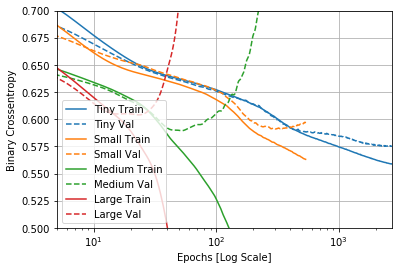

In [29]:
plotter.plot(size_histories)
a= plt.xscale('log')
plt.xlim([5,max(plt.xlim())])
plt.ylim([0.5,0.7])
plt.xlabel("Epochs [Log Scale]")

> 注意：一旦确定模型没有取得进展，上述所有训练运行都使用callbacks.EarlyStopping结束训练。
----

###在TensorBoard中查看
这些模型都在训练期间编写了TensorBoard日志。

要在笔记本中打开嵌入式TensorBoard查看器，请将以下内容复制到代码单元中：

In [31]:
!pip install tensorboard
%tensorboard --logdir {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.


您可以在TensorBoard.dev上查看此笔记本的上次运行结果。

TensorBoard.dev是一种托管体验，用于与所有人托管，跟踪和共享ML实验。

<iframe>为了方便起见，它也包含在其中：

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%",height="800px"
)

如果要共享TensorBoard结果，可以通过将以下内容复制到代码单元中来将日志上传到TensorBoard.dev。
> 注意：此步骤需要一个Google帐户。

In [33]:
!tensorboard dev upload --logdir {logdir}/sizes


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/tmp/tmp0ev5e2cg/tensorboard_logs/sizes

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) No


> 警告：此命令不会终止。它旨在连续上传长时间运行的实验结果。数据上传后，您需要使用笔记本工具中的“中断执行”选项将其停止。

###防止过度拟合的策略
在进入本节内容之前，请复制上述"Tiny"模型中的训练日志，以用作比较的基准。

In [34]:
shutil.rmtree(logdir/'regularizers/Tiny',ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny',logdir/'regularizers/Tiny')

PosixPath('/tmp/tmp0ev5e2cg/tensorboard_logs/regularizers/Tiny')

In [0]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

###增加体重调整
您可能熟悉Occam的Razor原理：给某事两种解释，最可能正确的解释是“最简单”的解释，即假设最少的一种。这也适用于由神经网络学习的模型：给定一些训练数据和网络体系结构，可以使用多组权重值（多个模型）来解释数据，并且较简单的模型比复杂的模型不太可能过拟合。

在这种情况下，“简单模型”是参数值的分布具有较小熵的模型（或如上节所述，具有总共较少参数的模型）。因此，减轻过度拟合的一种通用方法是通过仅将网络的权重强制取小的值来对网络的复杂性施加约束，这使得权重值的分布更加“规则”。这称为“权重调整”，它是通过向网络的损失函数中添加与权重较大相关的成本来完成的。此成本有两种口味：

* L1正则化，其中增加的成本与权重系数的绝对值成正比（即，权重的所谓“ L1范数”）。

* L2正则化，其中增加的成本与权重系数的值的平方成正比（即，权重的平方的“ L2范数”的平方）。L2正则化在神经网络中也称为权重衰减。不要让其他名称使您感到困惑：权重衰减在数学上与L2正则化完全相同。

L1正则化将权重推向正好为零，从而鼓励了稀疏模型。L2正则化将惩罚权重参数而不会使其稀疏，因为对于小权重，惩罚变为零。L2更常见的原因之一。

在中tf.keras，通过将权重正则化器实例作为关键字参数传递给图层来添加权重正则化。让我们现在添加L2权重正则化。

In [36]:
l2_model = tf.keras.Sequential([
  layers.Dense(512,activation='elu',
               kernel_regularizer=regularizers.l2(0.001),
               input_shape=(FEATURES,)),
  layers.Dense(512,activation='elu',
               kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(512,activation='elu',
               kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(512,activation='elu',
               kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(1,activation='sigmoid')
])
regularizer_histories['l2'] = compile_and_fit(l2_model,"regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5261,  binary_crossentropy:0.8001,  loss:2.3211,  val_accuracy:0.5810,  val_binary_crossentr

l2(0.001)意味着该层权重矩阵中的每个系数都会增加网络0.001 * weight_coefficient_value**2的总损耗。

这就是为什么我们要binary_crossentropy直接监控。因为它没有混入此正则化组件。

因此，"Large"具有L2正则化惩罚的相同模型的性能要好得多：

(0.5, 0.7)

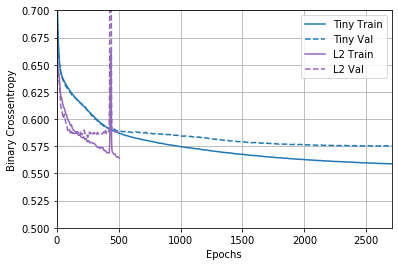

In [37]:
plotter.plot(regularizer_histories)
plt.ylim([0.5,0.7])

如您所见，"L2"正则化模型现在比模型更具竞争力"Tiny"。这种"L2"模式也更耐比过拟合"Large"，尽管有相同数量的参数，它是基于模型。

###更多信息
这种正则化有两点要注意。

**首先**：如果您正在编写自己的训练循环，则需要确保向模型询问其正则化损失。

In [0]:
result = l2_model(features)
regularization_loss = tf.add_n(l2_model.losses)

**第二**：此实现通过将权重损失添加到模型的损失中，然后在此之后应用标准优化过程来工作。

还有第二种方法，它只对原始损耗运行优化器，然后在应用计算出的步骤时，优化器还会应用一些权重衰减。这种“去耦的权重衰减”可在诸如optimizers.FTRL和的优化器中看到optimizers.AdamW。

### 添加辍学
辍学是Hinton和他在多伦多大学的学生开发的最有效，最常用的神经网络正则化技术之一。

辍学的直观解释是，由于网络中的各个节点不能依赖于其他节点的输出，因此每个节点必须输出自己有用的功能。

应用于图层的辍学包括在训练过程中随机“退出”（即设置为零）该图层的多个输出要素。假设在训练过程中，给定的图层通常会为给定的输入样本返回向量[0.2、0.5、1.3、0.8、1.1]；在应用dropout之后，此向量将有一些零个条目随机分布，例如[0、0.5、1.3、0、1.1]。

“辍学率”是被清零的特征的一部分。通常设置在0.2到0.5之间。在测试时，不会丢失任何单元，而是将图层的输出值按等于丢失率的因数进行缩小，以平衡比训练时活动的单元更多的事实。

在其中，tf.keras您可以通过Dropout层在网络中引入Dropout，该层将立即应用于该层的输出。

让我们在网络中添加两个Dropout层，看看它们在减少过度拟合方面的表现如何：

In [39]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

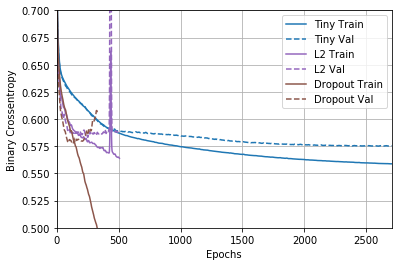

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5,0.7])

从该图中可以明显看出，这两种正则化方法都可以改善"Large"模型的行为。但这甚至没有超过"Tiny"基线。

接下来，将它们一起尝试，看看效果是否更好。

###L2 +组合辍学

In [41]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

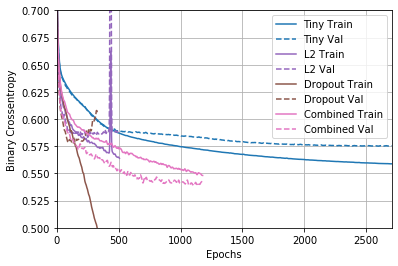

In [42]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

带有"Combined"正则化的模型显然是迄今为止最好的模型。

###在TensorBoard中查看
这些模型还记录了TensorBoard日志。

要在笔记本中打开嵌入式tensorboard查看器，请将以下内容复制到代码单元中：

In [0]:
%tensorboard --logdir {logdir}/regularizers

您可以在TensorDoard.dev上查看此笔记本的上次运行结果。

`<iframe>`为了方便起见，它也包含在其中：

In [0]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

上载到：

In [0]:
!tensorboard dev upload --logdir  {logdir}/regularizers

###结论
回顾一下：以下是防止神经网络过度拟合的最常用方法：

* 获取更多培训数据。
* 减少网络容量。
* 添加体重调整。
* 添加辍学。

本指南未涵盖的两种重要方法是：

* 数据增长
* 批量标准化

请记住，每种方法都可以单独提供帮助，但通常将它们组合起来会更加有效。